# 01 – Visualize barcode drug signatures

Notebook for downstream visualization of the barcode-based drug screen.

Input:
- `merged_logfc_pval_filtered_deseq2_2023_fillna.csv`: matrix of log2 fold-changes (one DESeq2 result per condition) already filtered on p-value and with missing values imputed.
- `colnames_annotated_2023.csv`: annotation of conditions (drug, class, etc.).

Outputs (saved in the `figures/` folder):
- Heatmap of barcode signatures (barcodes × conditions).
- Clustered correlation heatmap of conditions.
- Drug similarity network (conditions as nodes, correlation-based edges).


In [31]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

sns.set(context="notebook", style="white")
plt.rcParams["figure.dpi"] = 120

# Ensure output directory exists
FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


## 1. Config – paths and parameters

Adjust paths below if needed. They are written assuming:
- this notebook lives in `scripts/2023/` (or similar),
- data files live in `../data/` relative to the notebook.


In [32]:
# ---- Paths (edit if needed) ----
DATA_DIR = Path("../data")
SCRIPT_DIR = Path(".")

LOGFC_FILE = Path("./merged_logfc_pval_filtered_deseq2_2023_fillna.csv")
ANNOT_FILE = Path("./colnames_annotated_2023.csv")  # condition annotations

# ---- Core parameters ----
# Correlation threshold for network edges
CORR_THRESHOLD = 0.8

# Number of top variable barcodes to plot in Fig.3 (None = all)
# You can set this to e.g. 3000 if the full matrix is too heavy to display.
N_TOP_VARIABLE_BARCODES = None  # or an int

print("LOGFC_FILE:", LOGFC_FILE)
print("ANNOT_FILE:", ANNOT_FILE)
print("Figures will be saved to:", FIG_DIR.resolve())


LOGFC_FILE: merged_logfc_pval_filtered_deseq2_2023_fillna.csv
ANNOT_FILE: colnames_annotated_2023.csv
Figures will be saved to: E:\Downloads\Projects\2025_portfolio_github\portfolio\04_Postdoc_INSERM\07_Barcodes\notebooks\figures


## 2. Load log2FC matrix and annotation

The log2FC file is expected to have:
- rows: barcodes (or genomic features),
- columns: conditions (CtrlMs_000u, Temps0_000u, drugs, doses, experiments, etc.),
- all values: numeric log2 fold changes (after p-value filtering and imputation).

The annotation file is expected to contain per-condition information (e.g. drug class).


In [39]:
# Load log2FC matrix
logfc_df = pd.read_csv(LOGFC_FILE, sep=";", header=0, index_col=0)
print("Original logFC shape (rows × cols):", logfc_df.shape)

# Ensure numeric, coerce non-numeric to NaN then fill with 0 (should already be numeric & imputed)
logfc_df = logfc_df.apply(pd.to_numeric, errors="coerce")
logfc_df = logfc_df.fillna(0.0)

# Sort columns case-insensitively, like in your correlation script
logfc_df = logfc_df.reindex(sorted(logfc_df.columns, key=lambda x: x.lower()), axis=1)

print("LogFC matrix after cleaning:")
display(logfc_df.iloc[:5, :8])

# Load annotation of conditions (optional but highly recommended for nice plots)
if ANNOT_FILE.exists():
    annot_df = pd.read_csv(ANNOT_FILE, sep=";")
    # First column is condition name
    annot_df = annot_df.set_index(annot_df.columns[0])
    print("Annotation columns:", list(annot_df.columns))
    # Reindex to match conditions in logfc_df (safe subset)
    annot_df = annot_df.reindex(logfc_df.columns)
else:
    annot_df = None
    print("Warning: annotation file not found – plots will be unannotated.")


Original logFC shape (rows × cols): (2900, 121)
LogFC matrix after cleaning:


,Aliser_050n,Azacyt_1.5u,AZD148_005u,AZD818_050u,Bafilo_1.2n,BGJ398_007u,BMS536_002u,Bortez_020n
25,2.208141,0.0,0.000000,0.000000,0.000000,1.908868,0.0,0.000000
26,1.366701,0.0,0.000000,0.000000,0.000000,2.125775,0.0,-2.109738
27,1.884079,0.0,0.000000,0.000000,0.000000,2.141418,0.0,-1.860958
28,1.833700,0.0,1.678251,1.111202,0.000000,1.683830,0.0,5.852667
35,2.878087,0.0,0.000000,0.000000,2.305334,2.323701,0.0,0.000000


Annotation columns: ['annotation']


## 3. Optional: restrict to top variable barcodes

To avoid a gigantic heatmap, you can restrict to the most variable barcodes across conditions.
If `N_TOP_VARIABLE_BARCODES` is `None`, all barcodes are used.


In [40]:
if N_TOP_VARIABLE_BARCODES is not None and N_TOP_VARIABLE_BARCODES < logfc_df.shape[0]:
    variances = logfc_df.var(axis=1)
    top_idx = variances.sort_values(ascending=False).head(N_TOP_VARIABLE_BARCODES).index
    logfc_sub = logfc_df.loc[top_idx].copy()
    print(f"Using top {N_TOP_VARIABLE_BARCODES} most variable barcodes out of {logfc_df.shape[0]}.")
else:
    logfc_sub = logfc_df.copy()
    print("Using all barcodes:", logfc_sub.shape[0])


Using all barcodes: 2900


## 4. Fig.3 – Heatmap of barcode signatures

We reproduce the idea of your Fig.3:
- rows: barcodes,
- columns: conditions,
- values: column-wise normalized log2FC (z-score per condition),
- optional column annotation (drug classes, MOA, etc.).


Z-scored logFC shape: (2900, 121)
No suitable annotation column found for color mapping.


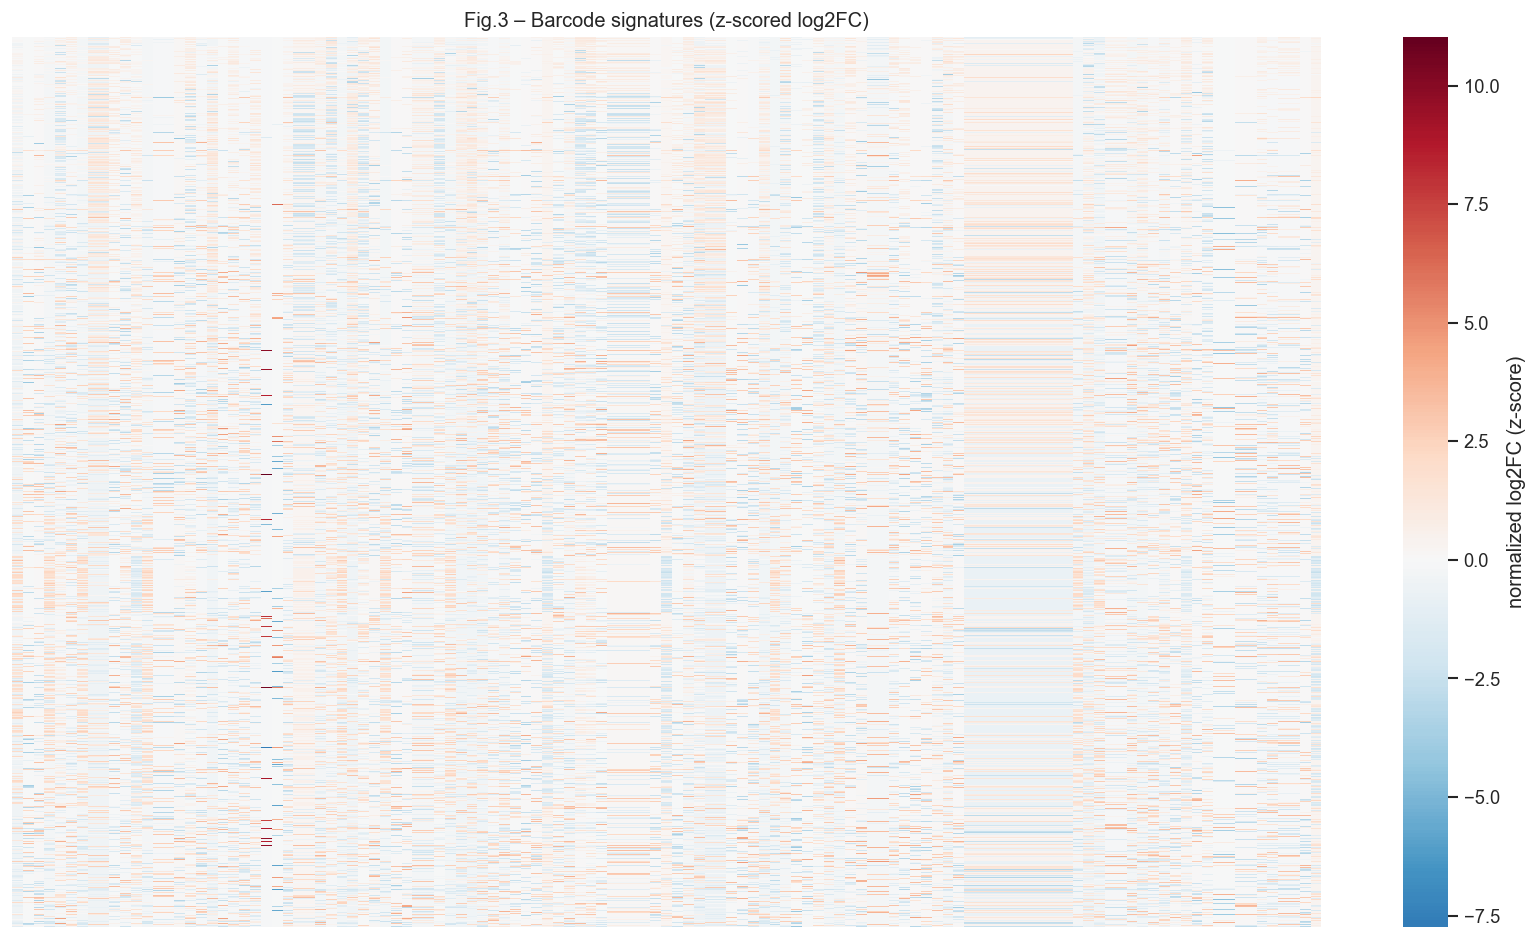

In [43]:
# Column-wise z-score (normalize each condition)
z_logfc = logfc_sub.copy()
z_logfc = (z_logfc - z_logfc.mean(axis=0)) / (z_logfc.std(axis=0, ddof=0) + 1e-9)

print("Z-scored logFC shape:", z_logfc.shape)

# Build annotation for seaborn, if available
col_colors = None
if annot_df is not None:
    # Choose one annotation column for coloring (modify if needed)
    # Example: a column named 'Class' or 'Mechanism' or similar.
    # If several exist, you can change this variable.
    annot_col_name = None
    for candidate in ["colname"]:
        if candidate in annot_df.columns:
            annot_col_name = candidate
            break

    if annot_col_name is not None:
        cond_to_class = annot_df[annot_col_name].astype(str)
        unique_classes = cond_to_class.unique()
        palette = sns.color_palette("tab20", n_colors=len(unique_classes))
        class_to_color = {c: palette[i] for i, c in enumerate(unique_classes)}
        col_colors = cond_to_class.map(class_to_color)
        print("Using annotation column for colors:", annot_col_name)
    else:
        print("No suitable annotation column found for color mapping.")

# Plot heatmap (rows not clustered, columns clustered or not as you prefer)
plt.figure(figsize=(14, 8))
sns.heatmap(
    z_logfc,
    cmap="RdBu_r",
    center=0,
    cbar_kws={"label": "normalized log2FC (z-score)"},
    xticklabels=False,
    yticklabels=False
)
plt.title("Fig.3 – Barcode signatures (z-scored log2FC)")
plt.tight_layout()
plt.savefig(FIG_DIR / "fig3_barcode_signatures_heatmap.png", dpi=300, bbox_inches="tight")
plt.savefig(FIG_DIR / "fig3_barcode_signatures_heatmap.pdf", bbox_inches="tight")
plt.show()


## 5. Fig.4 – Drug–drug correlation matrix

We compute the Pearson correlation between conditions using the log2FC values and plot a clustered heatmap.

- each column = one condition (drug/dose/experiment),
- each cell = correlation between two conditions,
- clustering on rows/columns gives the 2D drug map.


Correlation matrix shape: (121, 121)


c:\users\nina\appdata\local\programs\python\python37\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


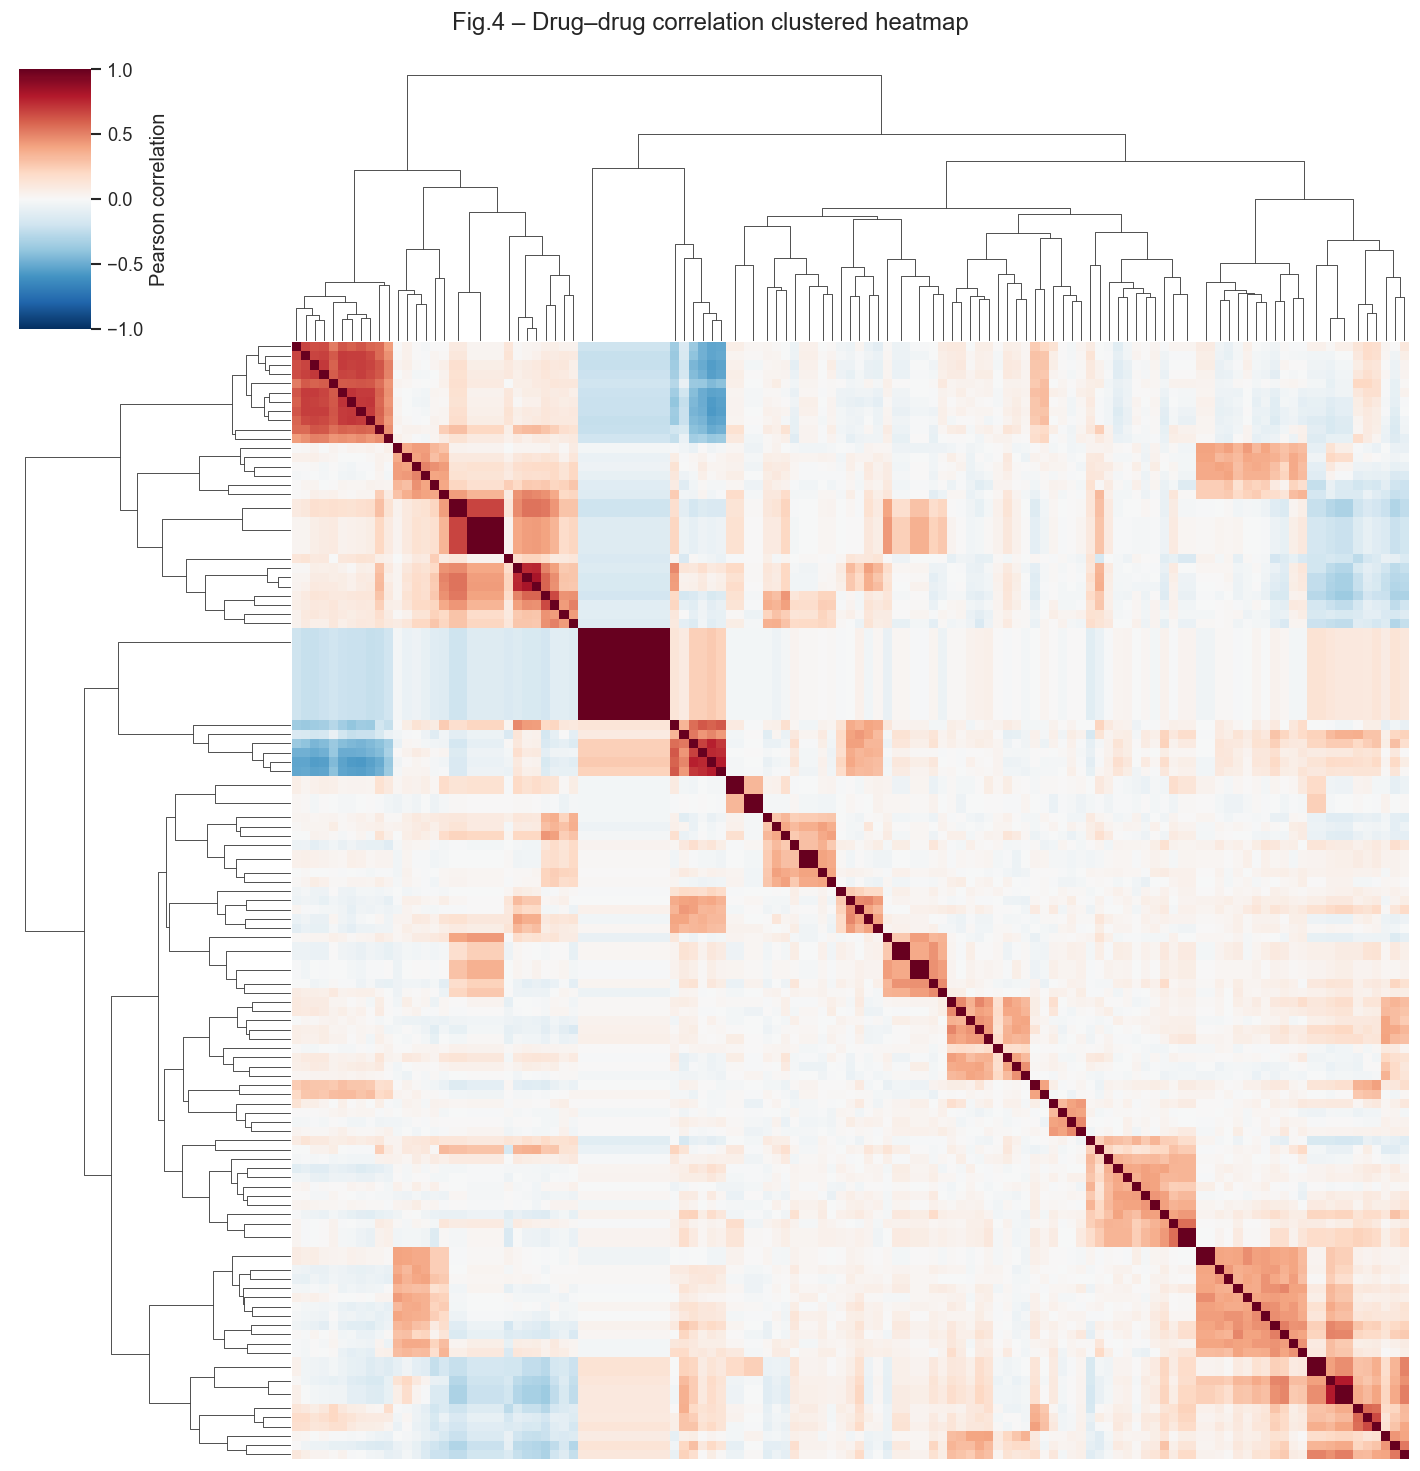

In [44]:
# Correlation between conditions (columns)
corr_mat = logfc_df.corr(method="pearson", min_periods=1)
print("Correlation matrix shape:", corr_mat.shape)

# Clustered heatmap of correlations
g = sns.clustermap(
    corr_mat,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    center=0,
    figsize=(12, 12),
    xticklabels=False,
    yticklabels=False,
    cbar_kws={"label": "Pearson correlation"},
    method="complete"
)
g.fig.suptitle("Fig.4 – Drug–drug correlation clustered heatmap", y=1.02)
plt.savefig(FIG_DIR / "fig4_drug_drug_correlation_clustered.png", dpi=300, bbox_inches="tight")
plt.savefig(FIG_DIR / "fig4_drug_drug_correlation_clustered.pdf", bbox_inches="tight")
plt.show()


## 6. Fig.5 – Drug network (correlation ≥ threshold)

We build an undirected graph:
- nodes = conditions,
- edge between two nodes if their correlation ≥ `CORR_THRESHOLD` (default 0.8),
- node color = drug class (if annotation available),
- layout = Fruchterman–Reingold (spring layout), like in your original description.


Number of nodes: 121
Number of edges (|r| >= 0.8 ): 62
No class annotation found for node coloring.


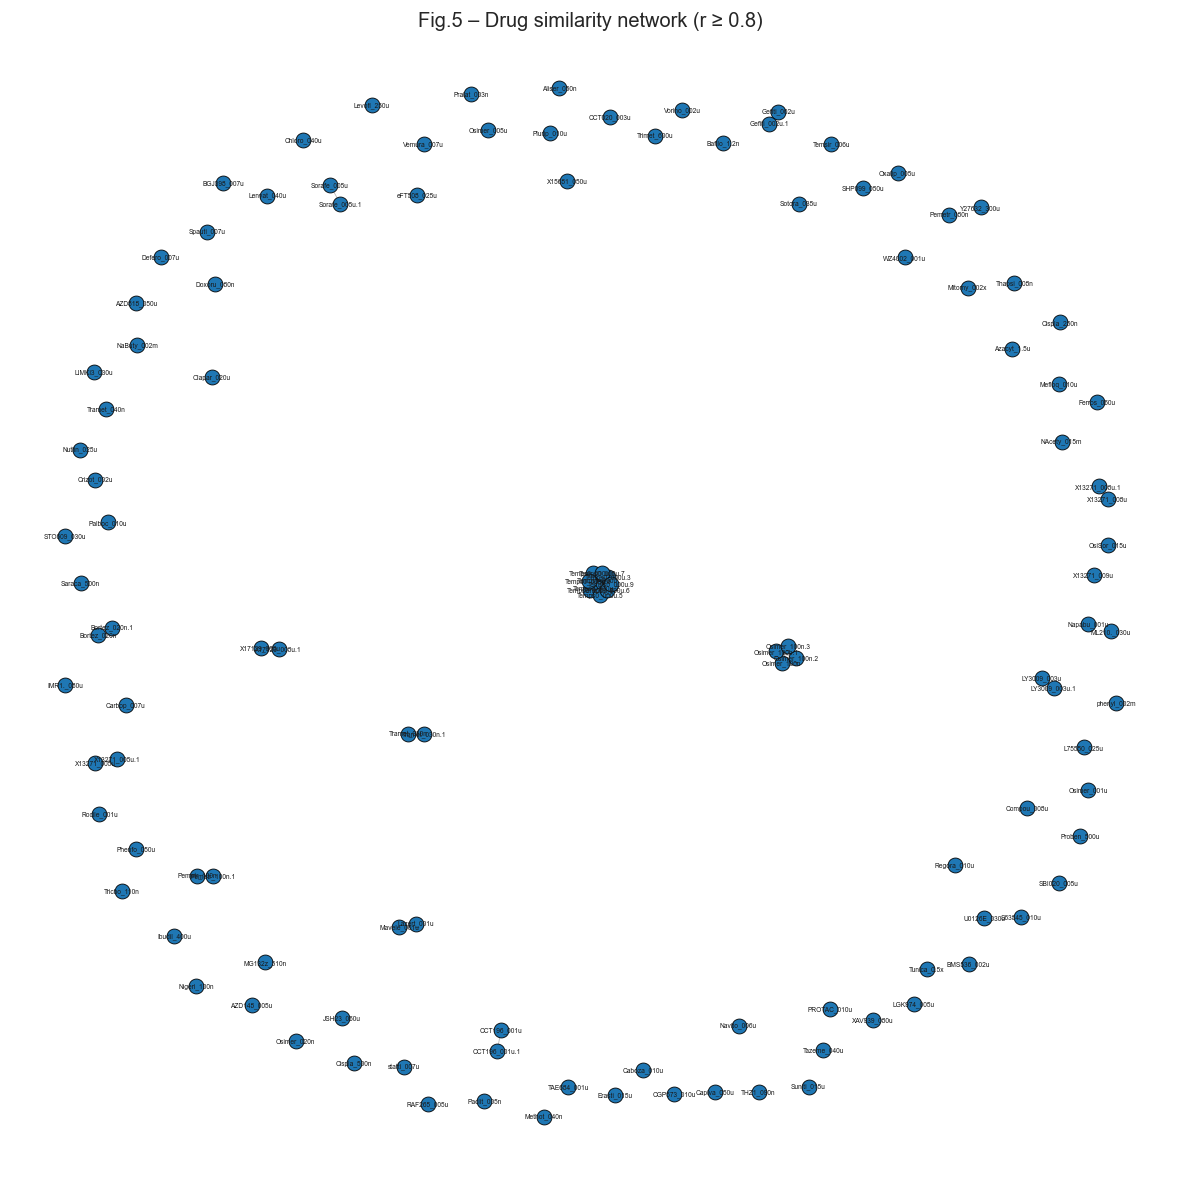

In [45]:
# Build graph from correlation matrix
G = nx.Graph()

# Add nodes with optional class attribute
for cond in corr_mat.columns:
    node_attrs = {}
    if annot_df is not None:
        # copy entire annotation row as attributes
        if cond in annot_df.index:
            for col in annot_df.columns:
                node_attrs[col] = annot_df.loc[cond, col]
    G.add_node(cond, **node_attrs)

# Add edges based on correlation threshold
for i, cond_i in enumerate(corr_mat.columns):
    for j, cond_j in enumerate(corr_mat.columns):
        if j <= i:
            continue
        r = corr_mat.loc[cond_i, cond_j]
        if r >= CORR_THRESHOLD:
            G.add_edge(cond_i, cond_j, weight=float(r))

print("Number of nodes:", G.number_of_nodes())
print("Number of edges (|r| >=", CORR_THRESHOLD, "):", G.number_of_edges())

# Choose node colors from a class attribute if available
node_classes = None
if annot_df is not None:
    for candidate in ["Class", "class", "DrugClass", "drug_class", "MOA", "moa"]:
        if candidate in annot_df.columns:
            node_classes = candidate
            break

if node_classes is not None:
    class_values = []
    for n in G.nodes:
        if n in annot_df.index:
            class_values.append(str(annot_df.loc[n, node_classes]))
        else:
            class_values.append("NA")
    unique_classes = sorted(set(class_values))
    palette = sns.color_palette("tab20", n_colors=len(unique_classes))
    class_to_color = {c: palette[i] for i, c in enumerate(unique_classes)}
    node_colors = [class_to_color[c] for c in class_values]
else:
    node_colors = "tab:blue"
    unique_classes = None
    class_to_color = None
    print("No class annotation found for node coloring.")

# Spring layout (Fruchterman–Reingold)
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=80, linewidths=0.5, edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=4)

plt.title(f"Fig.5 – Drug similarity network (r ≥ {CORR_THRESHOLD})")
plt.axis("off")
plt.tight_layout()
plt.savefig(FIG_DIR / "fig5_drug_network.png", dpi=300, bbox_inches="tight")
plt.savefig(FIG_DIR / "fig5_drug_network.pdf", bbox_inches="tight")
plt.show()

# Optional: legend for classes
if unique_classes is not None and class_to_color is not None:
    fig, ax = plt.subplots(figsize=(4, 4))
    for c in unique_classes:
        ax.scatter([], [], color=class_to_color[c], label=c, s=40)
    ax.legend(title=node_classes, frameon=False, fontsize=6)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(FIG_DIR / "fig5_drug_network_legend.png", dpi=300, bbox_inches="tight")
    plt.savefig(FIG_DIR / "fig5_drug_network_legend.pdf", bbox_inches="tight")
    plt.show()


## 7. Quick summary

This notebook:
- loads `merged_logfc_pval_filtered_deseq2_2023_fillna.csv`,
- optionally restricts to the most variable barcodes,
- generates three main figures:
  1. **Fig.3** – barcode signatures heatmap,
  2. **Fig.4** – clustered correlation heatmap of conditions,
  3. **Fig.5** – correlation-based drug similarity network.

All figures are saved in the `figures/` folder as both `.png` and `.pdf`.
